In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from glob import glob
import os, time
import xavierUtils as xu
import datetime as dt
%autosave 1000000

Autosaving every 1000000 seconds


### Carregando dados:

In [2]:
anoFiles = glob('../dados/despesas/baixado_2019-04-26/Ano-*.csv')
anoFiles.sort()
fileDate = pd.to_datetime(pd.Series([time.ctime(os.path.getmtime(anoFiles[-1]))]))[0]

In [3]:
despesas = pd.concat([pd.read_csv(a, sep=';') for a in anoFiles], ignore_index=True)
# despesas['numDia'] = despesas.datEmissao.str.split('T').str.get(0).str.split('-').str.get(-1)
colNames = despesas.columns.values

### Dados faltantes:

In [4]:
xu.checkMissing(despesas)

Colunas com valores faltantes:
                       coluna            N      %
1                 ideCadastro         4674   0.13
2       nuCarteiraParlamentar         4667   0.13
4                        sgUF         4674   0.13
5                   sgPartido         4674   0.13
10  txtDescricaoEspecificacao  2.87515e+06  79.81
13                  txtNumero            9      0
15                 datEmissao       183850    5.1
16               vlrDocumento           17      0
22              txtPassageiro  2.68342e+06  74.49
23                  txtTrecho  2.67053e+06  74.13
25           numRessarcimento  1.96483e+06  54.54
26             vlrRestituicao  3.60176e+06  99.98


In [ ]:
print ',  '.join(despesas.loc[despesas.ideCadastro.isnull()].txNomeParlamentar.unique())

### Verificando identificadores de deputado/entidade:

In [ ]:
def ColunasBiunivocas(base, colA, colB):
    temp = base[[colA,colB]].groupby(colA)[colB].nunique()
    return len(temp)==np.sum(temp)

In [ ]:
print ColunasBiunivocas(despesas.loc[despesas.ideCadastro.isnull()==False],'ideCadastro','nuDeputadoId')
print ColunasBiunivocas(despesas,'ideCadastro','nuDeputadoId')
print ColunasBiunivocas(despesas,'txNomeParlamentar','nuDeputadoId')
print ColunasBiunivocas(despesas,'nuDeputadoId','txNomeParlamentar')

In [ ]:
# Nome com duplicidade de DepId:
numIdByDep = despesas.groupby('txNomeParlamentar')['nuDeputadoId'].nunique()
numIdByDep.loc[numIdByDep>1]

In [ ]:
# Id das lideranças:
despesas.loc[despesas.ideCadastro.isnull()].groupby('txNomeParlamentar')['nuDeputadoId'].unique()

In [ ]:
# CONCLUSÃO: nuDeputadoId é o melhor identificador, sendo que lideranças/partidos são identificados por falta de 
# idCadastro.

### Outras colunas:

In [ ]:
xu.mapUnique(despesas)

### Verificação dos valores:

In [ ]:
# Valores negativos de documentos são bilhetes aéreos não utilizados, segundo o dadosabertos:
print ',  '.join(despesas.loc[despesas.vlrDocumento<0].txtDescricao.unique())

In [ ]:
# Existem valores líquidos negativos que não são passagens, e eles são estranhos.
print ',  '.join(despesas.loc[despesas.vlrLiquido<0].txtDescricao.unique())
#despesas.loc[(despesas.vlrLiquido<0) & 
#             (despesas.numSubCota!=999)].to_csv('../dados/despesas_com_vlrLiquido_estranhos.csv',
#                                               index=False, sep=';')

In [ ]:
# Quando valor líquido existe, não existe valor de restituição:
despesas.loc[despesas.vlrLiquido!=0]['vlrRestituicao'].unique()

In [ ]:
# Quando existe valor de restituição, não existe valor líquido:
print '# Restituições com valor líquido não-nulo:',\
len(despesas.loc[(despesas.vlrRestituicao.isnull()==False)&(despesas.vlrLiquido!=0)])

In [ ]:
# Valores de restituição restituem quase tudo:
print ',  '.join(despesas.loc[(despesas.vlrRestituicao.isnull()==False)]['txtDescricao'].unique())

In [ ]:
despesas.loc[(despesas.nuDeputadoId==1810) & (despesas.numSubCota==3) & (despesas.numAno==2014) & 
            (despesas.vlrLiquido<0)]\
[['txNomeParlamentar','numAno','numMes','txtDescricao','vlrDocumento','vlrGlosa','vlrLiquido','vlrRestituicao']]

In [ ]:
despesas.loc[(despesas.nuDeputadoId==620) & (despesas.numSubCota==10) & (despesas.numAno==2011) & 
            (despesas.vlrLiquido==0.19)]\
[['txNomeParlamentar','numAno','numMes','txtDescricao','vlrDocumento','vlrGlosa','vlrLiquido','vlrRestituicao']]

In [ ]:
despesas.loc[(despesas.vlrLiquido<0) & (despesas.numSubCota!=999)][['nuDeputadoId','numSubCota','numAno']]

### Deflacionando

In [5]:
# Carregando ipca:
ipca         = pd.read_csv('../dados/economicos/ipca_2019-04-26.csv')
ipca['data'] = pd.to_datetime([str(ano)+'-'+str(mes).zfill(2)+'-01' for ano,mes in zip(ipca.ano.values,ipca.mes.values)])

# Juntando ipca à base de despesas:
despesas['dataCompetencia'] = pd.to_datetime([str(ano)+'-'+str(mes).zfill(2)+'-01' 
                                              for ano,mes in zip(despesas.numAno.values,despesas.numMes.values)])
despesas = despesas.join(ipca.set_index('data',drop=True)['indice'], on='dataCompetencia')
despesas.rename(axis='columns',mapper={'indice':'ipca'},inplace=True)

In [6]:
# Deflacionar para Janeiro de 2019:
ipcaRef = ipca.loc[(ipca.ano==2019)&(ipca.mes==1)]['indice'].values[0]
print ipcaRef

1318.7004


In [7]:
# Calcula valores reais:
despesas['vlrLiqReal']  = despesas['vlrLiquido']/despesas['ipca']*ipcaRef
despesas['vlrRestReal'] = despesas['vlrRestituicao']/despesas['ipca']*ipcaRef

### Gastos por tipo

In [8]:
gastosByTipo = despesas.loc[despesas.numMes<2018].groupby('txtDescricao')['vlrLiqReal'].sum()
gastosTotais = gastosByTipo.sum()
fracGastosByTipo = (gastosByTipo/gastosTotais).sort_values()

In [42]:
fracGastosByTipo

txtDescricao
PARTICIPAÇÃO EM CURSO, PALESTRA OU EVENTO SIMILAR               0.000195
PASSAGENS TERRESTRES, MARÍTIMAS OU FLUVIAIS                     0.000225
LOCAÇÃO OU FRETAMENTO DE EMBARCAÇÕES                            0.000353
AQUISIÇÃO DE MATERIAL DE ESCRITÓRIO.                            0.000383
AQUISIÇÃO OU LOC. DE SOFTWARE; SERV. POSTAIS; ASS.              0.000667
ASSINATURA DE PUBLICAÇÕES                                       0.001275
SERVIÇO DE TÁXI, PEDÁGIO E ESTACIONAMENTO                       0.002001
LOCOMOÇÃO, ALIMENTAÇÃO E  HOSPEDAGEM                            0.003801
SERVIÇO DE SEGURANÇA PRESTADO POR EMPRESA ESPECIALIZADA.        0.007021
FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR                      0.008240
LOCAÇÃO OU FRETAMENTO DE AERONAVES                              0.008267
HOSPEDAGEM ,EXCETO DO PARLAMENTAR NO DISTRITO FEDERAL.          0.009828
PASSAGENS AÉREAS                                                0.023758
SERVIÇOS POSTAIS                      

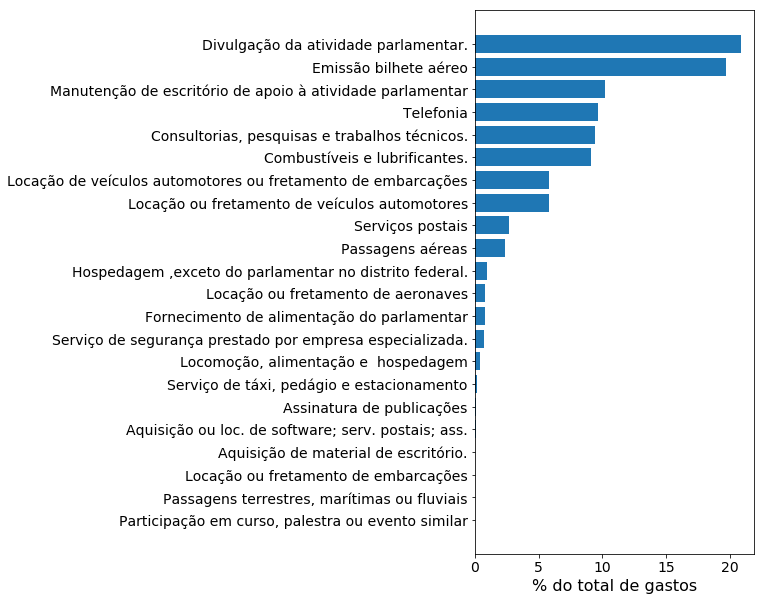

In [41]:
gastosByTipoLabels = map(lambda s: unicode(s[0],'utf-8')+unicode(s[1:],'utf-8').lower(), fracGastosByTipo.index.values)
x = np.arange(1,len(fracGastosByTipo)+1)

pl.figure(figsize=(5,10))
pl.barh(x,100*fracGastosByTipo.values)
pl.yticks(x,gastosByTipoLabels)
pl.xlabel(u'% do total de gastos', fontsize=16)
pl.gca().tick_params(labelsize=14)
#xu.saveFigWdate('graficos/total-despesas-por-tipo.pdf')
pl.show()

In [10]:
xu.one2oneQ(despesas,'txtDescricao','numSubCota')

True

In [11]:
despesas.groupby('txtDescricao')['numSubCota'].unique().sort_index()

txtDescricao
AQUISIÇÃO DE MATERIAL DE ESCRITÓRIO.                              [6]
AQUISIÇÃO OU LOC. DE SOFTWARE; SERV. POSTAIS; ASS.                [7]
ASSINATURA DE PUBLICAÇÕES                                        [12]
COMBUSTÍVEIS E LUBRIFICANTES.                                     [3]
CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.                     [4]
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                              [5]
Emissão Bilhete Aéreo                                           [999]
FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR                       [13]
HOSPEDAGEM ,EXCETO DO PARLAMENTAR NO DISTRITO FEDERAL.           [14]
LOCAÇÃO DE VEÍCULOS AUTOMOTORES OU FRETAMENTO DE EMBARCAÇÕES     [15]
LOCAÇÃO OU FRETAMENTO DE AERONAVES                              [119]
LOCAÇÃO OU FRETAMENTO DE EMBARCAÇÕES                            [121]
LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES                   [120]
LOCOMOÇÃO, ALIMENTAÇÃO E  HOSPEDAGEM                              [2]
MANUTEN

### Cálculo do valor gasto

In [34]:
# Passagens aéreas:
#despSel       = despesas.loc[despesas.numSubCota.isin([9,999,119])]
# Divulgação:
#despSel       = despesas.loc[despesas.numSubCota.isin([5])]
# Consultorias:
#despSel       = despesas.loc[despesas.numSubCota.isin([4])]
# Tudo:
despSel       = despesas.loc[despesas.dataCompetencia>'2009-06-01']

restituicoes  = despSel.groupby(['numAno','numMes'])['vlrRestReal'].sum()
reembolsos    = despSel.groupby(['numAno','numMes'])['vlrLiqReal'].sum()
gastosMensais = pd.DataFrame(restituicoes).join(reembolsos, how='outer')
gastosMensais['vlrGastoReal'] = gastosMensais.vlrLiqReal - gastosMensais.vlrRestReal
gReal = gastosMensais.vlrGastoReal.values

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
g1st      = gastosMensais.index[0]
gTest     = gReal[gastosMensais.index.get_level_values('numAno')<2018]
gastosIdx = pd.date_range(start=str(g1st[0])+'-'+str(g1st[1]).zfill(2)+'-01', periods=len(gTest),freq='M')
gastosTS  = pd.Series(gTest, index=gastosIdx)
result = seasonal_decompose(gastosTS, model='additive')

In [36]:
fullIdx = pd.date_range(start=str(g1st[0])+'-'+str(g1st[1]).zfill(2)+'-01', periods=len(gReal),freq='M')
fullTS  = pd.Series(gReal, index=fullIdx)

In [37]:
gastosGrid = pd.Series(fullIdx)
anoLegislatura = gastosGrid[(gastosGrid.dt.month.values==1)&(gastosGrid.dt.year.isin([2011,2015,2019]))]

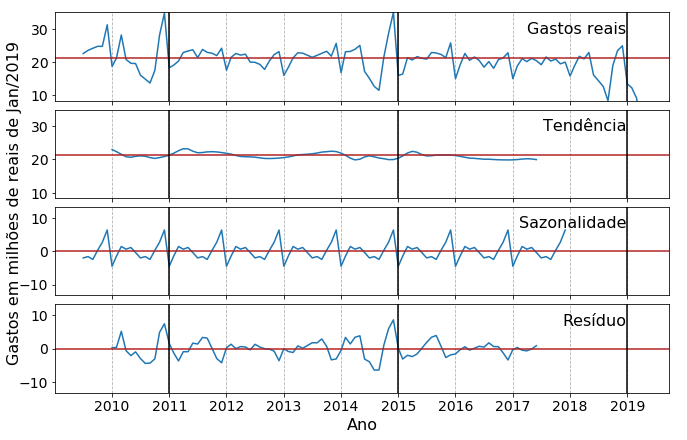

In [38]:
scaleTxt = {0:u'reais',3:u'milhares de reais',6:u'milhões de reais',9:u'bilhões de reais'}
scaleExp = (int(np.log10(np.mean(gReal)))/3*3)
scale  = 10**scaleExp
ymin   = gReal[gReal>0].min()/scale
ymax   = gReal[gReal>0].max()/scale
deltay = ymax-ymin
gMean  = np.mean(gTest)/scale

fig = pl.figure(figsize=(11,7))

# Observed:
ax1 = pl.subplot(4,1,1)
pl.text(0.93,0.9,'Gastos reais', horizontalalignment='right', verticalalignment='top', transform=pl.gca().transAxes, 
       fontsize=16)
pl.plot(fullTS/scale)
pl.ylim([ymin,ymax])
pl.gca().tick_params(labelsize=14)
pl.axhline(gMean,color='firebrick')
# Format x-axis:
pl.xticks(gastosGrid[gastosGrid.dt.month.values==1].values)
pl.grid(axis='x', linestyle='--')
pl.gca().tick_params(labelbottom=False)
# Novas legislaturas:
[pl.axvline(a, color='k') for a in anoLegislatura]

# Trend:
pl.subplot(4,1,2, sharex=ax1)
pl.text(0.93,0.9,u'Tendência', horizontalalignment='right', verticalalignment='top', transform=pl.gca().transAxes, 
       fontsize=16)
pl.plot(result.trend/scale)
pl.ylim([ymin,ymax])
pl.gca().tick_params(labelsize=14)
pl.axhline(gMean,color='firebrick')
# Format x-axis:
pl.xticks(fullIdx[fullIdx.month==1])
pl.grid(axis='x', linestyle='--')
pl.gca().tick_params(labelbottom=False)
# Novas legislaturas:
[pl.axvline(a, color='k') for a in anoLegislatura]

# Seasonal:
pl.subplot(4,1,3, sharex=ax1)
pl.text(0.93,0.9,'Sazonalidade', horizontalalignment='right', verticalalignment='top', transform=pl.gca().transAxes, 
       fontsize=16)

pl.plot(result.seasonal/scale)
pl.ylim([-deltay/2, deltay/2])
pl.gca().tick_params(labelsize=14)
# Format x-axis:
pl.xticks(fullIdx[fullIdx.month==1])
pl.grid(axis='x', linestyle='--')
pl.gca().tick_params(labelbottom=False)
pl.axhline(0,color='firebrick')
# Novas legislaturas:
[pl.axvline(a, color='k') for a in anoLegislatura]

# Residual:
pl.subplot(4,1,4, sharex=ax1)
pl.text(0.93,0.9,u'Resíduo', horizontalalignment='right', verticalalignment='top', transform=pl.gca().transAxes, 
       fontsize=16)
pl.plot(result.resid/scale)
pl.ylim([-deltay/2, deltay/2])
pl.gca().tick_params(labelsize=14)
# Format x-axis:
pl.xticks(fullIdx[fullIdx.month==1])
pl.grid(axis='x', linestyle='--')
pl.axhline(0,color='firebrick')
pl.xlabel('Ano', fontsize=16)
# Novas legislaturas:
[pl.axvline(a, color='k') for a in anoLegislatura]


# Label x comum:
axComum = fig.add_subplot(111, frameon=False)
pl.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axComum.set_ylabel(u'Gastos em '+scaleTxt[scaleExp]+' de Jan/2019', fontsize=16)

# Ajustes finais:
pl.gca().tick_params(labelsize=14)
pl.subplots_adjust(hspace=0.1)
#xu.saveFigWdate('graficos/despesas-reais-e-sazonalidade.pdf')
pl.show()

In [39]:
result.seasonal

2009-07-31   -2.012900e+06
2009-08-31   -1.618820e+06
2009-09-30   -2.460643e+06
2009-10-31    2.787995e+05
2009-11-30    2.698769e+06
2009-12-31    6.372182e+06
2010-01-31   -4.524160e+06
2010-02-28   -1.490970e+06
2010-03-31    1.419186e+06
2010-04-30    6.132502e+05
2010-05-31    1.116494e+06
2010-06-30   -3.911893e+05
2010-07-31   -2.012900e+06
2010-08-31   -1.618820e+06
2010-09-30   -2.460643e+06
2010-10-31    2.787995e+05
2010-11-30    2.698769e+06
2010-12-31    6.372182e+06
2011-01-31   -4.524160e+06
2011-02-28   -1.490970e+06
2011-03-31    1.419186e+06
2011-04-30    6.132502e+05
2011-05-31    1.116494e+06
2011-06-30   -3.911893e+05
2011-07-31   -2.012900e+06
2011-08-31   -1.618820e+06
2011-09-30   -2.460643e+06
2011-10-31    2.787995e+05
2011-11-30    2.698769e+06
2011-12-31    6.372182e+06
                  ...     
2015-07-31   -2.012900e+06
2015-08-31   -1.618820e+06
2015-09-30   -2.460643e+06
2015-10-31    2.787995e+05
2015-11-30    2.698769e+06
2015-12-31    6.372182e+06
2

### Teste com valores

In [ ]:
# Carregando ipca:
ipca = pd.read_csv('../dados/economicos/ipca_2019-04-15.csv')
ipca = ipca.reindex(index=ipca.index[::-1]).reset_index(drop=True)
ipcaIdx = ipca.loc[ipca.ano>=2011].indice
ipcaMesSeq = np.arange(1,1+len(ipcaIdx))

In [ ]:
# Ajuste linear ao IPCA:
linReg = linear_model.LinearRegression()
linReg.fit(np.transpose([ipcaMesSeq]),ipcaIdx)
ipcaPred = linReg.predict(np.transpose([ipcaMesSeq]))

In [ ]:
# Extrapola o IPCA para os meses que faltam:
ipcaExtrapMes = np.arange(ipcaMesSeq[-1],1+ipcaMesSeq[-1]+len(dTotalArr)-len(ipcaMesSeq))
ipcaExtrapIdx = linReg.predict(np.transpose([ipcaExtrapMes]))
ipcaExtrapIdx = ipcaExtrapIdx - ipcaExtrapIdx[0] + ipcaIdx.iloc[-1]

In [ ]:
pl.plot(ipcaMesSeq,ipcaIdx,'b-',label='Real')
pl.plot(ipcaMesSeq,ipcaPred,'r-',label='Linear')
pl.plot(ipcaExtrapMes,ipcaExtrapIdx,'k-',label='Extrap.')
pl.legend()
pl.show()

In [ ]:
ipcaFinal = np.concatenate((ipcaIdx,ipcaExtrapIdx[1:]))

### Deflacionando e juntando valores por mês e ano

In [ ]:
#### ATENÇÃO!!! É preciso corrigir o último mês dos gastos pelo número de dias existentes e 
####            extrapolar o IPCA para os meses que não existem !!

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Calcula despesas totais e agrupa por ano e mês:

restituicoes  = despesas.groupby(['numAno','numMes'])['vlrRestituicao'].sum()
reembolsos    = despesas.groupby(['numAno','numMes'])['vlrLiquido'].sum()
gastosMensais = pd.DataFrame(restituicoes).join(reembolsos, how='outer')
dTotal = gastosMensais.vlrLiquido - gastosMensais.vlrRestituicao

dNum   = despesas.groupby(['numAno','numMes']).size()
mesSeq = np.arange(1,len(dTotal)+1)
dTotalArr = np.array(dTotal)
dNumArr = np.array(dNum)

In [ ]:
pl.figure(figsize=(15,5))
pl.plot(mesSeq,dNumArr,'r-')
pl.axvline(0*12+1,color='black',linestyle='-')
pl.axvline(1*12+1,color='gray',linestyle='--')
pl.axvline(2*12+1,color='gray',linestyle='--')
pl.axvline(3*12+1,color='gray',linestyle='--')
pl.axvline(4*12+1,color='black',linestyle='-')
pl.axvline(5*12+1,color='gray',linestyle='--')
pl.axvline(6*12+1,color='gray',linestyle='--')
pl.axvline(7*12+1,color='gray',linestyle='--')
pl.axvline(8*12+1,color='black',linestyle='-')
pl.xlabel('# do mes a partir de Jan/2011')
pl.ylabel('# de despesas registradas')
pl.show()

In [ ]:
pl.figure(figsize=(15,5))
pl.plot(mesSeq,dTotalArr,'r-')
pl.axvline(0*12+1,color='black',linestyle='-')
pl.axvline(1*12+1,color='gray',linestyle='--')
pl.axvline(2*12+1,color='gray',linestyle='--')
pl.axvline(3*12+1,color='gray',linestyle='--')
pl.axvline(4*12+1,color='black',linestyle='-')
pl.axvline(5*12+1,color='gray',linestyle='--')
pl.axvline(6*12+1,color='gray',linestyle='--')
pl.axvline(7*12+1,color='gray',linestyle='--')
pl.axvline(8*12+1,color='black',linestyle='-')
pl.xlabel('# do mes a partir de Jan/2011')
pl.ylabel('Despesas totais nominais')
pl.show()

In [ ]:
# Carregando ipca:
ipca = pd.read_csv('../dados/economicos/ipca_2019-04-15.csv')
ipca = ipca.reindex(index=ipca.index[::-1]).reset_index(drop=True)
ipcaIdx = ipca.loc[ipca.ano>=2011].indice
ipcaMesSeq = np.arange(1,1+len(ipcaIdx))

In [ ]:
# Ajuste linear ao IPCA:
linReg = linear_model.LinearRegression()
linReg.fit(np.transpose([ipcaMesSeq]),ipcaIdx)
ipcaPred = linReg.predict(np.transpose([ipcaMesSeq]))

In [ ]:
# Extrapola o IPCA para os meses que faltam:
ipcaExtrapMes = np.arange(ipcaMesSeq[-1],1+ipcaMesSeq[-1]+len(dTotalArr)-len(ipcaMesSeq))
ipcaExtrapIdx = linReg.predict(np.transpose([ipcaExtrapMes]))
ipcaExtrapIdx = ipcaExtrapIdx - ipcaExtrapIdx[0] + ipcaIdx.iloc[-1]

In [ ]:
pl.plot(ipcaMesSeq,ipcaIdx,'b-',label='Real')
pl.plot(ipcaMesSeq,ipcaPred,'r-',label='Linear')
pl.plot(ipcaExtrapMes,ipcaExtrapIdx,'k-',label='Extrap.')
pl.legend()
pl.show()

In [ ]:
ipcaFinal = np.concatenate((ipcaIdx,ipcaExtrapIdx[1:]))

In [ ]:
pl.figure(figsize=(15,5))
pl.plot(mesSeq,dTotalArr/ipcaFinal*ipcaFinal[-1],'r-')
pl.axvline(0*12+1,color='black',linestyle='-')
pl.axvline(1*12+1,color='gray',linestyle='--')
pl.axvline(2*12+1,color='gray',linestyle='--')
pl.axvline(3*12+1,color='gray',linestyle='--')
pl.axvline(4*12+1,color='black',linestyle='-')
pl.axvline(5*12+1,color='gray',linestyle='--')
pl.axvline(6*12+1,color='gray',linestyle='--')
pl.axvline(7*12+1,color='gray',linestyle='--')
pl.axvline(8*12+1,color='black',linestyle='-')
pl.xlabel('# do mes a partir de Jan/2011')
pl.ylabel('Despesas totais reais')
pl.axhline(2e7,color='g')
pl.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
gastosTS = pd.Series(dTotalArr, index=pd.date_range(start='2011-01-01',periods=100,freq='M'))
result = seasonal_decompose(gastosTS/ipcaFinal*ipcaFinal[-1], model='additive')
result.plot()
pl.show()

### Gastos por categoria

In [ ]:
despesas.groupby('numSubCota')['txtDescricao'].unique().apply(lambda x: x[0])

In [ ]:
hyperClasse = dict(zip(sorted([  1,   3,   5,   9,  13,  14,  15,   4,  10,  11, 999,   8,  12,
       122, 120, 119, 121, 123, 137]),['Escritorio de apoio','Transporte terrestre','Informacao',
                                                     'Divulgacao','Outros', 'Transporte aereo','Comunicacao',
                                                     'Comunicacao','Informacao','Alimentacao','Hospedagem',
                                                     'Transporte terrestre','Transporte aereo','Transporte terrestre',
                                                     'Transporte terrestre', 'Transporte terrestre', 
                                                     'Transporte terrestre', 'Informacao','Transporte aereo']))

In [ ]:
anoBase = 2017
nGastos       = despesas.loc[despesas.numAno==anoBase].groupby('numSubCota').size()
restituicoes  = despesas.loc[despesas.numAno==anoBase].groupby('numSubCota')['vlrRestituicao'].sum()
reembolsos    = despesas.loc[despesas.numAno==anoBase].groupby('numSubCota')['vlrLiquido'].sum()
gastosByTipo  = pd.DataFrame(restituicoes).join(reembolsos, how='outer')

In [ ]:
nGastos       = despesas.groupby('numSubCota').size()
restituicoes  = despesas.groupby('numSubCota')['vlrRestituicao'].sum()
reembolsos    = despesas.groupby('numSubCota')['vlrLiquido'].sum()
gastosByTipo  = pd.DataFrame(restituicoes).join(reembolsos, how='outer')

gastosByTipo['fracRestituido'] = gastosByTipo.vlrRestituicao/gastosByTipo.vlrLiquido
gastosByTipo['vlrFinal']       = gastosByTipo.vlrLiquido - gastosByTipo.vlrRestituicao
gastosByTipo['fracTotal'] = gastosByTipo.vlrFinal / gastosByTipo.vlrFinal.sum()
gastosByTipo['hyperClasse'] = np.vectorize(hyperClasse.get)(gastosByTipo.index.values)

In [ ]:
gastosByTipo.groupby('hyperClasse')['fracTotal'].sum()

In [ ]:
fracTipoGasto = gastosByTipo.groupby('hyperClasse')['fracTotal'].sum().sort_values(ascending=True)
pl.pie(fracTipoGasto.values, startangle=90, labels=fracTipoGasto.index.values)
pl.show()

# Lixo

In [ ]:
# Função que seria para marcar anos e meses especiais, abandonada:
def seasonMarks(mes0,ano0,mes1,ano1):
    nSteps = (ano1-ano0)*12 + (mes1-mes0)

In [ ]:
despesas.numDia.fillna('01', inplace=True)

In [ ]:
ultimasD = despesas.iloc[-500000:]
ultimasD = pd.to_datetime(ultimasD.numAno*10000+ultimasD.numMes*100+ultimasD.numDia.astype(int),
                          format='%Y%m%d', errors='coerce')
ultimasD.loc[ultimasD.isnull()==False].sort_values().iloc[-1]

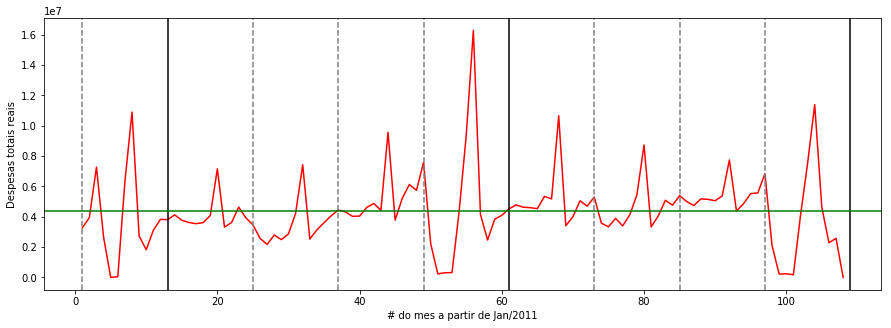

In [117]:
pl.figure(figsize=(15,5))

gReal  = gastosMensais.vlrGastoReal.values
mesSeq = np.arange(1,len(gReal)+1)

pl.plot(mesSeq,gReal,'r-')
pl.axvline(0*12+1,color='gray',linestyle='--')
pl.axvline(1*12+1,color='black',linestyle='-')
pl.axvline(2*12+1,color='gray',linestyle='--')
pl.axvline(3*12+1,color='gray',linestyle='--')
pl.axvline(4*12+1,color='gray',linestyle='--')
pl.axvline(5*12+1,color='black',linestyle='-')
pl.axvline(6*12+1,color='gray',linestyle='--')
pl.axvline(7*12+1,color='gray',linestyle='--')
pl.axvline(8*12+1,color='gray',linestyle='--')
pl.axvline(9*12+1,color='black',linestyle='-')

pl.xlabel('# do mes a partir de Jan/2011')
pl.ylabel('Despesas totais reais')
pl.axhline(np.mean(gReal),color='g')
pl.show()